In [ ]:
# Cell 1: Imports & helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# extra metrics
def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b != 0))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(safe_divide(y_true - y_pred, y_true)))

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / np.where(denom == 0, 1, denom))

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ev = explained_variance_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'R2': r2, 'ExplainedVar': ev, 'MAPE': mape, 'sMAPE': smape}


In [3]:
# Cell 2: load_and_preprocess_data (updated: optional outlier removal)
def load_and_preprocess_data(filepath='dataset.csv', verbose=True, remove_outliers=True):
    """
    Load CSV, basic cleaning, and optional extreme-outlier removal.
    remove_outliers=True -> remove rows that have ANY numeric value outside [q1-3*IQR, q3+3*IQR].
    """
    if verbose: print("Loading dataset...")
    df = pd.read_csv(filepath)
    if verbose: print(f'Original shape: {df.shape}')
    # standardize column names
    df.columns = [c.strip().replace(' ', '_') for c in df.columns]

    # keep a copy of raw if caller wants to visualize before-cleaning
    # (caller can read CSV separately for before/after plots)

    # timestamps
    if {'LastUpdatedDate', 'LastUpdatedTime'}.issubset(df.columns):
        df['LastUpdatedTimestamp'] = pd.to_datetime(
            df['LastUpdatedDate'].astype(str) + ' ' + df['LastUpdatedTime'].astype(str),
            format='%d-%m-%Y %H:%M:%S', errors='coerce'
        )
    elif 'LastUpdatedTimestamp' in df.columns:
        df['LastUpdatedTimestamp'] = pd.to_datetime(df['LastUpdatedTimestamp'], errors='coerce')
    else:
        raise ValueError("Timestamp columns not found. Provide LastUpdatedDate+LastUpdatedTime or LastUpdatedTimestamp.")

    # drop exact duplicates
    dup_count = df.duplicated().sum()
    if verbose: print(f'Duplicates found: {dup_count}')
    df = df.drop_duplicates().reset_index(drop=True)

    # strip whitespace for object cols
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip()

    # numeric & categorical lists
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols and c != 'LastUpdatedTimestamp']

    # impute numeric with median
    num_imputer = SimpleImputer(strategy='median')
    if len(num_cols) > 0:
        df[num_cols] = pd.DataFrame(num_imputer.fit_transform(df[num_cols]), columns=num_cols)

    # categorical fill
    for c in cat_cols:
        df[c] = df[c].fillna('Unknown').astype(str)

    # mild clipping by IQR (keep values within q1-3iqr .. q3+3iqr)
    for c in num_cols:
        if df[c].nunique() > 5:
            q1, q3 = df[c].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower, upper = q1 - 3*iqr, q3 + 3*iqr
            df[c] = df[c].clip(lower, upper)

    # Optional: remove extreme rows (any numeric feature outside [q1-3iqr, q3+3iqr])
    if remove_outliers and len(num_cols) > 0:
        extreme_mask = pd.Series(False, index=df.index)
        for c in num_cols:
            if df[c].nunique() > 5:
                q1, q3 = df[c].quantile([0.25, 0.75])
                iqr = q3 - q1
                lower, upper = q1 - 3*iqr, q3 + 3*iqr
                extreme_mask |= (df[c] < lower) | (df[c] > upper)
        n_removed = int(extreme_mask.sum())
        if verbose: print(f'Removing {n_removed} extreme rows based on 3*IQR rule.')
        if n_removed > 0:
            df = df.loc[~extreme_mask].reset_index(drop=True)

    # Generate base occupancy features
    if {'Occupancy', 'Capacity'}.issubset(df.columns):
        df['OccupancyRate'] = df['Occupancy'] / df['Capacity'].replace({0: np.nan})
        df['OccupancyRate'] = df['OccupancyRate'].fillna(0).clip(0,1.5)
        df['occupancy_over_capacity_flag'] = (df['Occupancy'] > df['Capacity']).astype(int)
    else:
        df['OccupancyRate'] = 0.0

    # time features
    df['Hour'] = df['LastUpdatedTimestamp'].dt.hour
    df['DayOfWeek'] = df['LastUpdatedTimestamp'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['Month'] = df['LastUpdatedTimestamp'].dt.month

    # traffic mapping
    if 'TrafficConditionNearby' in df.columns:
        traffic_map = {'low':0,'average':1,'high':2}
        df['TrafficLevel'] = df['TrafficConditionNearby'].map(lambda x: traffic_map.get(str(x).lower(),1)).astype(float)
    else:
        df['TrafficLevel'] = 1.0

    # vehicle weight mapping
    if 'VehicleType' in df.columns:
        vmap = {'cycle':0.3,'bike':0.5,'car':1.0,'truck':1.5}
        df['VehicleWeight'] = df['VehicleType'].map(lambda x: vmap.get(str(x).lower(),1.0)).astype(float)
    else:
        df['VehicleWeight'] = 1.0

    # queue normalization
    if 'QueueLength' in df.columns:
        maxq = df['QueueLength'].max()
        df['QueueNorm'] = df['QueueLength'] / (maxq if maxq and maxq>0 else 1)
    else:
        df['QueueNorm'] = 0.0

    if 'IsSpecialDay' not in df.columns:
        df['IsSpecialDay'] = 0

    if verbose: print(f'Processed shape: {df.shape}')
    return df


In [4]:
# Cell 3: construct_features and create_demand_pricing_model
def construct_features(df, verbose=True):
    group_col = 'SystemCodeNumber' if 'SystemCodeNumber' in df.columns else None
    target = 'OccupancyRate'
    lags = [1,2,3]
    df = df.sort_values(['SystemCodeNumber','LastUpdatedTimestamp']) if group_col else df.sort_values('LastUpdatedTimestamp')
    for lag in lags:
        if group_col:
            df[f'{target}_lag{lag}'] = df.groupby(group_col)[target].shift(lag)
        else:
            df[f'{target}_lag{lag}'] = df[target].shift(lag)
    if group_col:
        df[f'{target}_rm3'] = df.groupby(group_col)[target].rolling(window=3, min_periods=1).mean().reset_index(0,drop=True)
    else:
        df[f'{target}_rm3'] = df[target].rolling(window=3, min_periods=1).mean()
    df['Occupancy_x_Queue'] = df['OccupancyRate'] * df['QueueNorm']
    df['VehicleWeight_x_Traffic'] = df['VehicleWeight'] * df['TrafficLevel']
    df['IsPeakHour'] = df['Hour'].isin([7,8,9,17,18,19]).astype(int)
    lag_cols = [c for c in df.columns if 'lag' in c or 'rm' in c]
    if 'SystemCodeNumber' in df.columns:
        for grp, gdf in df.groupby('SystemCodeNumber'):
            for col in lag_cols:
                df.loc[gdf.index, col] = gdf[col].fillna(method='ffill').fillna(0)
    else:
        df[lag_cols] = df[lag_cols].fillna(method='ffill').fillna(0)
    if verbose: print("Constructed features:", lag_cols + ['Occupancy_x_Queue','VehicleWeight_x_Traffic','IsPeakHour'])
    return df

def create_demand_pricing_model(df, verbose=True):
    base_price = 10
    lambda_ = 0.8
    alpha,beta,gamma,delta,epsilon = 3.0,2.0,1.5,4.0,1.0
    df['DemandScore'] = (
        alpha * df.get('OccupancyRate_lag1', df['OccupancyRate']) +
        beta  * df.get('QueueNorm', 0) -
        gamma * df.get('TrafficLevel', 1) +
        delta * df['IsSpecialDay'] +
        epsilon* df.get('VehicleWeight', 1.0)
    )
    mn, mx = df['DemandScore'].min(), df['DemandScore'].max()
    df['DemandNorm'] = 0.0 if mn==mx else (df['DemandScore'] - mn) / (mx - mn)
    df['Price'] = base_price * (1 + lambda_ * df['DemandNorm'])
    df['Price'] = np.clip(df['Price'], base_price*0.5, base_price*2.0)
    if verbose: print("Demand price range:", df['Price'].min(), df['Price'].max())
    return df


In [5]:
# Cell 4: lagged split, tests, and plotting helpers
def create_lagged_features_and_split(df, lags=[1,2,3], train_ratio=0.7, val_ratio=0.15):
    lag1_col = 'OccupancyRate_lag1'
    if lag1_col in df.columns:
        df = df.dropna(subset=[lag1_col]).reset_index(drop=True)
    df = df.sort_values('LastUpdatedTimestamp').reset_index(drop=True)
    n = len(df)
    train_size = int(n * train_ratio); val_size = int(n * val_ratio)
    train_data = df.iloc[:train_size].reset_index(drop=True)
    val_data   = df.iloc[train_size:train_size+val_size].reset_index(drop=True)
    test_data  = df.iloc[train_size+val_size:].reset_index(drop=True)
    return train_data, val_data, test_data

def understand_relationships_and_test(train_data, sample_cols=None, verbose=True):
    if sample_cols is None:
        sample_cols = [c for c in ['Price','DemandNorm','OccupancyRate','QueueNorm','TrafficLevel','VehicleWeight'] if c in train_data.columns]
    if verbose:
        print("Correlation matrix for sample columns:")
        print(train_data[sample_cols].corr())
        try:
            sns.pairplot(train_data[sample_cols].sample(min(500, len(train_data))), diag_kind='kde', plot_kws={'alpha':0.4})
            plt.suptitle('Pairplot (sample)', y=1.02); plt.show()
        except Exception:
            pass
    if 'Price' in train_data.columns and 'IsWeekend' in train_data.columns:
        weekend = train_data[train_data['IsWeekend']==1]['Price']
        weekday = train_data[train_data['IsWeekend']==0]['Price']
        tstat, pval = stats.ttest_ind(weekend, weekday, equal_var=False, nan_policy='omit')
        if verbose: print(f"T-test Price weekend vs weekday: t={tstat:.3f}, p={pval:.3g}")
    if 'DayOfWeek' in train_data.columns:
        groups = [g['Price'].values for _, g in train_data.groupby('DayOfWeek') if len(g)>5]
        if len(groups) > 1:
            fstat, pval = stats.f_oneway(*groups)
            if verbose: print(f"ANOVA Price across DayOfWeek: F={fstat:.3f}, p={pval:.3g}")
    if 'TrafficConditionNearby' in train_data.columns and 'IsSpecialDay' in train_data.columns:
        ct = pd.crosstab(train_data['TrafficConditionNearby'], train_data['IsSpecialDay'])
        try:
            chi2, p, dof, ex = stats.chi2_contingency(ct)
            if verbose: print(f"Chi-square traffic vs specialday: chi2={chi2:.3f}, p={p:.3g}")
        except Exception:
            pass

def plot_price_distribution(df):
    plt.figure(figsize=(8,4)); sns.histplot(df['Price'], kde=True); plt.title('Price Distribution'); plt.show()

def plot_feature_correlation(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[feature_cols].corr()
    plt.figure(figsize=(10,8)); sns.heatmap(corr, cmap='coolwarm'); plt.title('Feature Correlation'); plt.show()

def plot_actual_vs_pred(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(6,6)); plt.scatter(y_true, y_pred, alpha=0.4)
    lims = [min(min(y_true), min(y_pred)), max(max(y_true), max(y_pred))]
    plt.plot(lims, lims, '--'); plt.xlabel('Actual Price'); plt.ylabel('Predicted Price'); plt.title(title); plt.show()


In [6]:
# Visualize numeric columns with boxplots (before / after)
def visualize_boxplots(df, cols=None, title="Boxplots", figsize=(14,6)):
    """
    Draw boxplots for the selected numeric columns.
    If cols is None, pick a compact set of numeric columns to visualize.
    """
    if cols is None:
        numeric = df.select_dtypes(include=[np.number]).columns.tolist()
        # pick a compact set to avoid overcrowding
        cols = [c for c in ['OccupancyRate','QueueNorm','TrafficLevel','VehicleWeight','Price'] if c in numeric]
        # fallback to first 6 numeric cols
        if not cols:
            cols = numeric[:6]
    if len(cols) == 0:
        print("No numeric columns to plot.")
        return
    n = len(cols)
    plt.figure(figsize=figsize)
    for i, c in enumerate(cols, 1):
        plt.subplot(1, n, i)
        sns.boxplot(y=df[c], orient='v')
        plt.title(c)
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [7]:
# Cell 5: feature selection & proximity
def select_features_and_reduce(train_data, val_data, feature_candidates, target_col='Price', k=12, verbose=True):
    X_train = train_data[feature_candidates].fillna(0)
    y_train = train_data[target_col]
    skb = SelectKBest(score_func=f_regression, k=min(k, X_train.shape[1]))
    skb.fit(X_train, y_train)
    selected_univariate = [f for f, s in zip(feature_candidates, skb.get_support()) if s]
    if verbose: print("Univariate selected:", selected_univariate)
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    imp = pd.Series(rf.feature_importances_, index=feature_candidates).sort_values(ascending=False)
    if verbose:
        print("Top RF importances:", imp.head(10))
        sns.barplot(x=imp.values[:10], y=imp.index[:10]); plt.title('Top RF Feature Importances (train)'); plt.show()
    final_features = list(dict.fromkeys(selected_univariate + imp.head(k).index.tolist()))
    if verbose: print("Final feature set (combined):", final_features)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    pca = PCA(n_components=min(5, X_train_scaled.shape[1]))
    pca.fit(X_train_scaled)
    if verbose:
        print("PCA explained variance ratios:", pca.explained_variance_ratio_)
        plt.plot(np.cumsum(pca.explained_variance_ratio_)); plt.xlabel('Components'); plt.ylabel('Cumulative explained var'); plt.show()
    return final_features, scaler, pca

def compute_proximity_measures(train_df, feature_cols):
    X = train_df[feature_cols].fillna(0).values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    def euclidean(a,b): return np.linalg.norm(a-b)
    def cosine(a,b): return 1 - (np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-9))
    cov = np.cov(Xs, rowvar=False)
    try:
        cov_inv = np.linalg.pinv(cov)
        def mahal(a,b): return np.sqrt((a-b).T @ cov_inv @ (a-b))
    except Exception:
        def mahal(a,b): return euclidean(a,b)
    nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(Xs)
    return {'scaler':scaler, 'nbrs':nbrs, 'euclidean':euclidean, 'cosine':cosine, 'mahal':mahal, 'Xs':Xs}


In [8]:
# Cell 5.1: train_and_evaluate_models definition
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def train_and_evaluate_models(train_data, val_data, test_data, feature_columns):
    """
    Train RandomForest and GradientBoosting on given feature_columns and return models, results, importances.
    """
    print("Training RandomForest & GradientBoosting on selected features...")
    X_train = train_data[feature_columns].fillna(0)
    y_train = train_data['Price']
    X_val = val_data[feature_columns].fillna(0)
    y_val = val_data['Price']
    X_test = test_data[feature_columns].fillna(0)
    y_test = test_data['Price']
    print('Feature matrix shapes:', X_train.shape, X_val.shape, X_test.shape)

    models = {
        'RandomForest': RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.04, max_depth=6, random_state=42)
    }
    results = {}
    importances = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        results[name] = {
            'train_metrics': compute_metrics(y_train, train_pred),
            'val_metrics': compute_metrics(y_val, val_pred),
            'test_metrics': compute_metrics(y_test, test_pred),
            'test_pred': test_pred
        }

        if hasattr(model, 'feature_importances_'):
            importances[name] = pd.Series(model.feature_importances_, index=feature_columns).sort_values(ascending=False)
        else:
            importances[name] = pd.Series(0, index=feature_columns)

    # Comparative table for quick view
    comp = []
    for name in models.keys():
        tm = results[name]['test_metrics']
        comp.append({
            'Model': name,
            'RMSE': tm['RMSE'],
            'MAE': tm['MAE'],
            'R2': tm['R2'],
            'MAPE(%)': tm['MAPE'] * 100,
            'sMAPE(%)': tm['sMAPE'] * 100
        })
    comp_df = pd.DataFrame(comp).sort_values('RMSE').reset_index(drop=True)
    print("Model comparison on TEST set:")
    display(comp_df)

    return models, results, importances


Boxplots BEFORE cleaning:


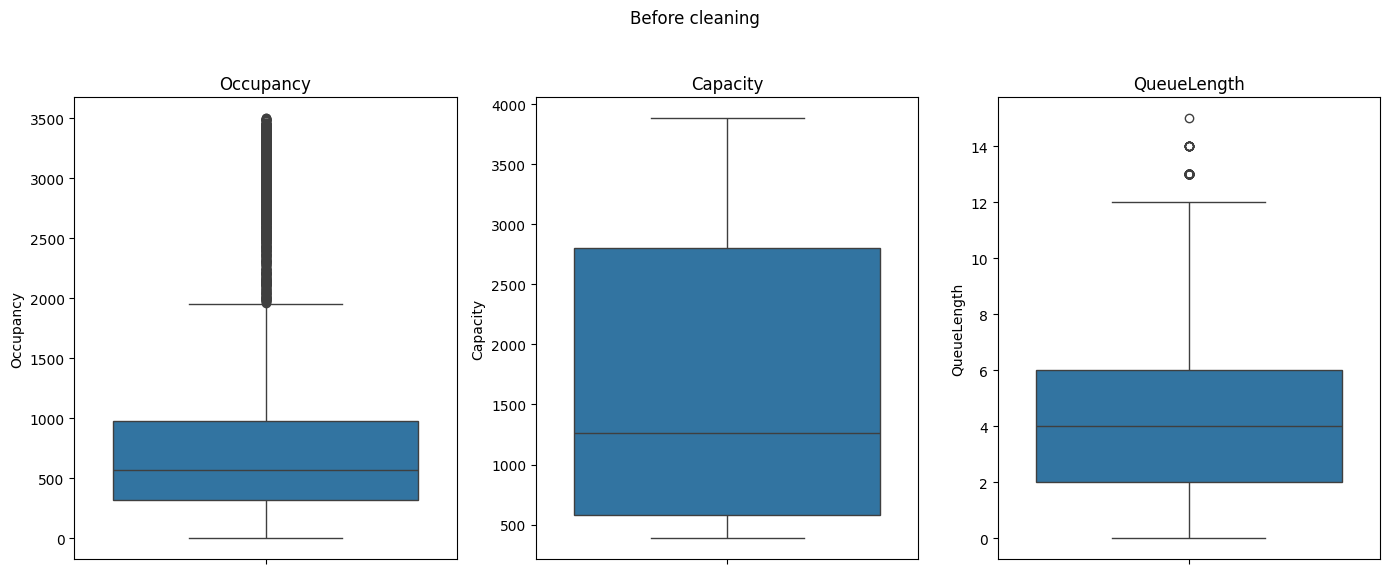

Loading dataset...
Original shape: (18368, 12)
Duplicates found: 0
Removing 0 extreme rows based on 3*IQR rule.
Processed shape: (18368, 22)
Constructed features: ['occupancy_over_capacity_flag', 'QueueNorm', 'OccupancyRate_lag1', 'OccupancyRate_lag2', 'OccupancyRate_lag3', 'OccupancyRate_rm3', 'Occupancy_x_Queue', 'VehicleWeight_x_Traffic', 'IsPeakHour']
Demand price range: 10.0 18.0

Boxplots AFTER cleaning & feature engineering:


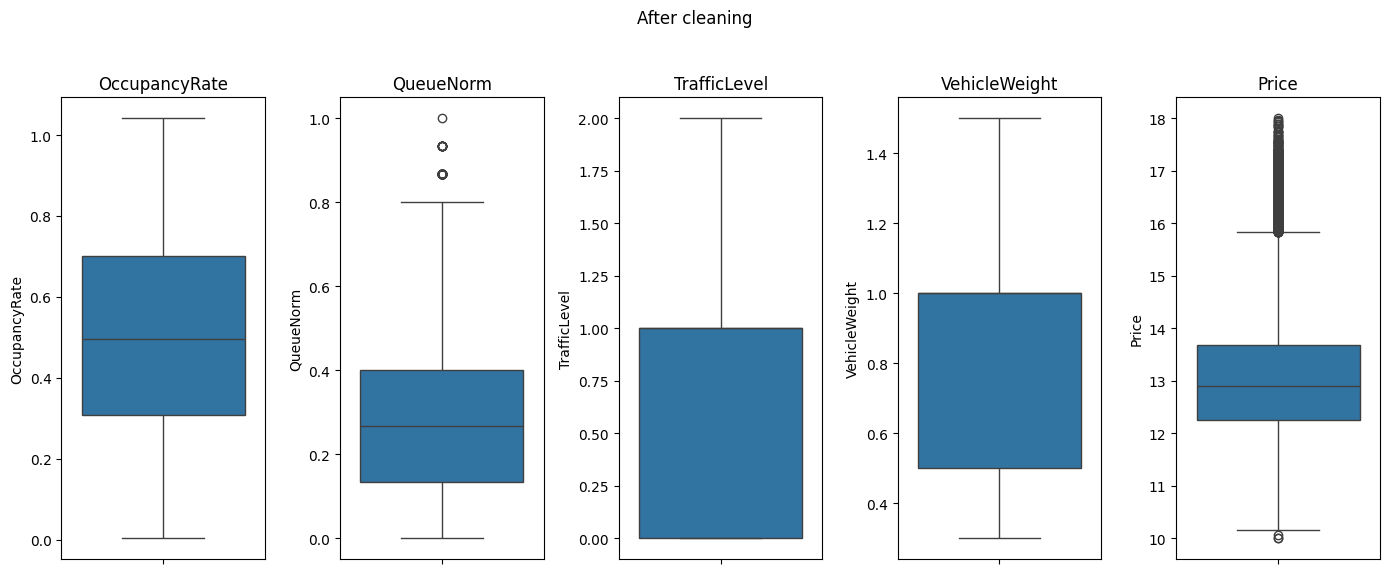

Train/Val/Test sizes: 12857/2755/2756
Correlation matrix for sample columns:
                  Price  DemandNorm  OccupancyRate  QueueNorm  TrafficLevel  \
Price          1.000000    1.000000       0.043102  -0.200326     -0.446161   
DemandNorm     1.000000    1.000000       0.043102  -0.200326     -0.446161   
OccupancyRate  0.043102    0.043102       1.000000   0.252195      0.260987   
QueueNorm     -0.200326   -0.200326       0.252195   1.000000      0.870281   
TrafficLevel  -0.446161   -0.446161       0.260987   0.870281      1.000000   
VehicleWeight  0.216334    0.216334      -0.003683  -0.023098     -0.019891   

               VehicleWeight  
Price               0.216334  
DemandNorm          0.216334  
OccupancyRate      -0.003683  
QueueNorm          -0.023098  
TrafficLevel       -0.019891  
VehicleWeight       1.000000  


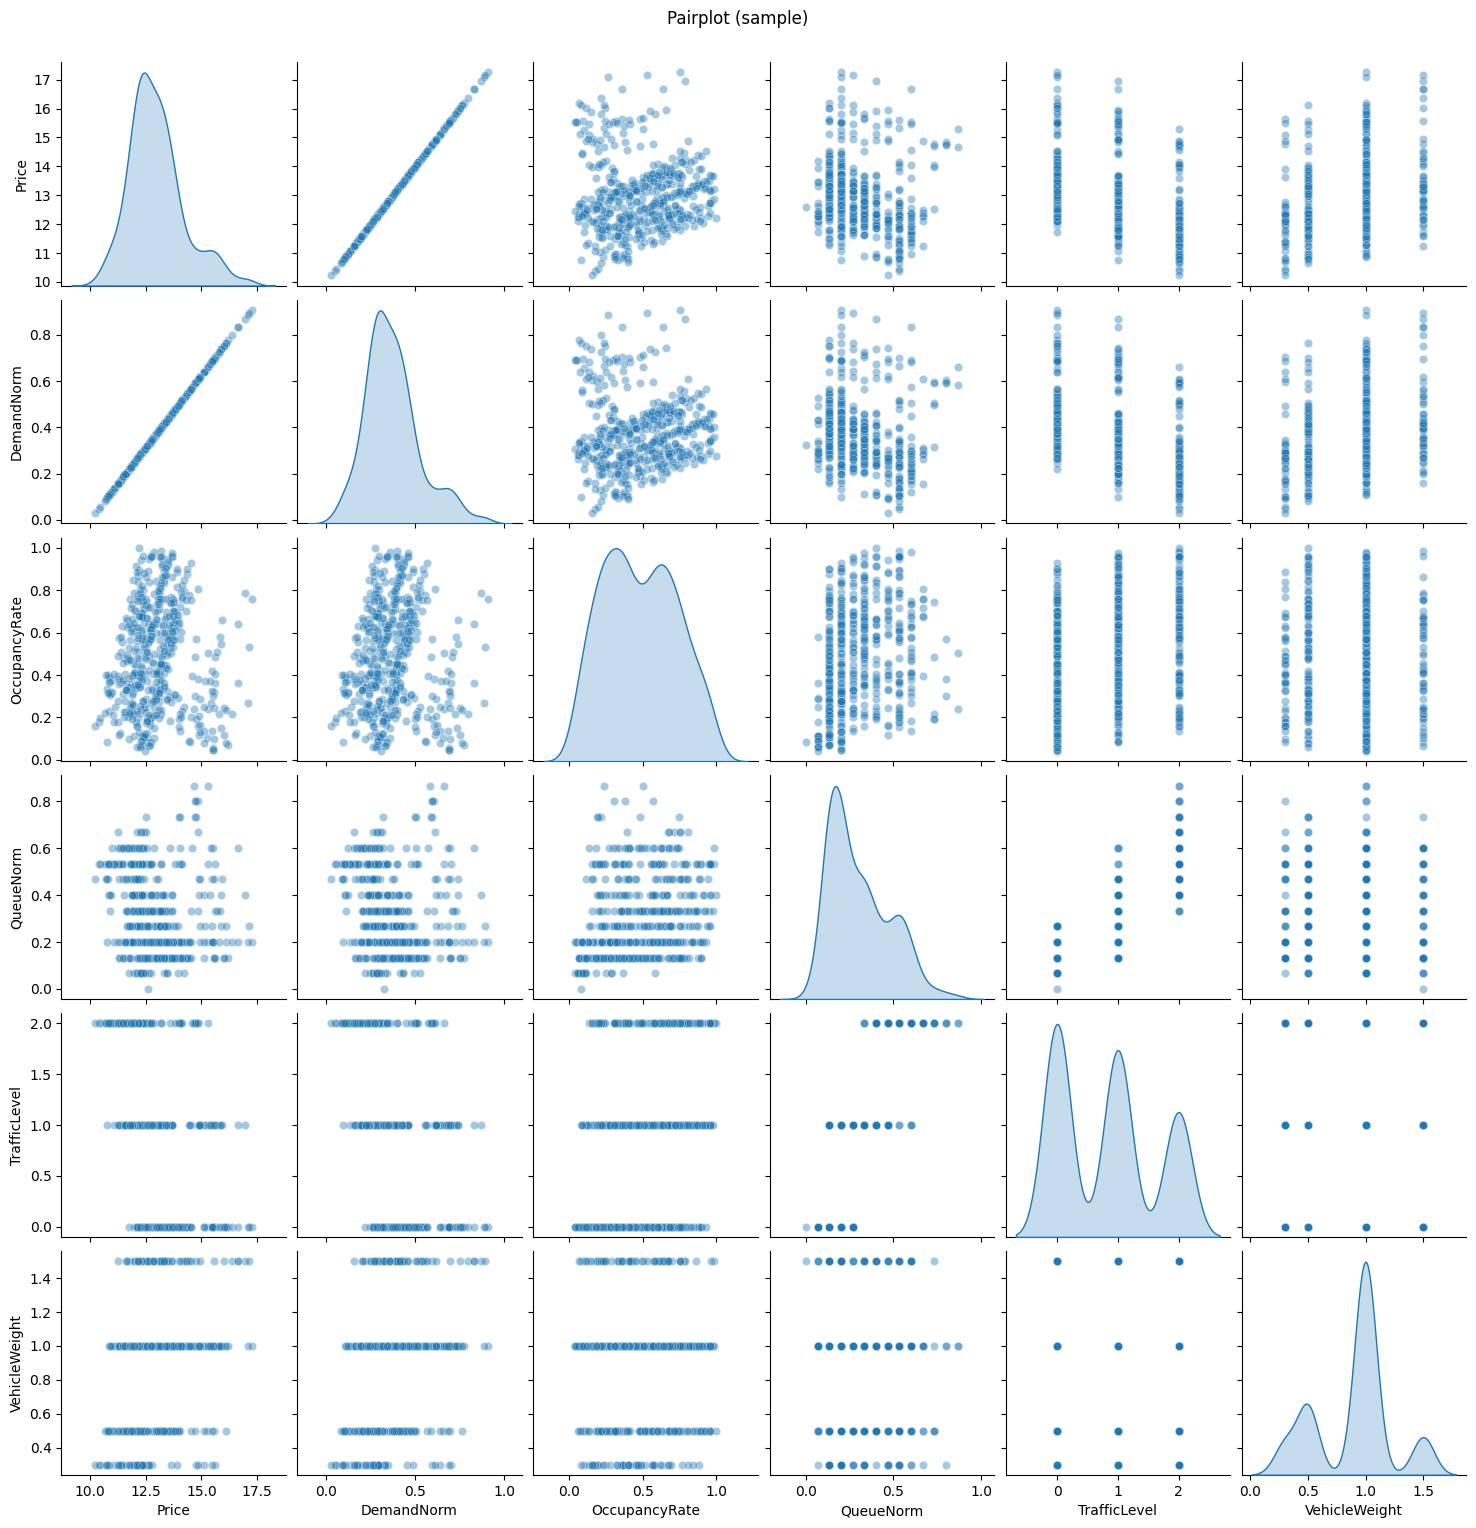

T-test Price weekend vs weekday: t=37.942, p=2.91e-270
ANOVA Price across DayOfWeek: F=3057.124, p=0
Chi-square traffic vs specialday: chi2=1.226, p=0.542
Univariate selected: ['Capacity', 'Latitude', 'OccupancyRate_lag2', 'OccupancyRate_lag3', 'QueueNorm', 'TrafficLevel', 'IsSpecialDay', 'VehicleWeight', 'DayOfWeek', 'IsWeekend', 'Occupancy_x_Queue', 'VehicleWeight_x_Traffic']
Top RF importances: DayOfWeek                  0.287562
IsSpecialDay               0.287073
OccupancyRate_lag1         0.149430
TrafficLevel               0.120370
VehicleWeight_x_Traffic    0.091892
VehicleWeight              0.026408
Occupancy_x_Queue          0.022617
OccupancyRate_rm3          0.012056
OccupancyRate_lag2         0.001354
QueueNorm                  0.000623
dtype: float64


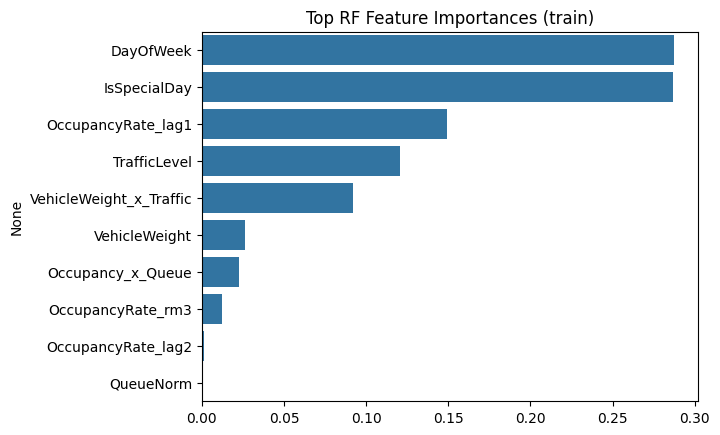

Final feature set (combined): ['Capacity', 'Latitude', 'OccupancyRate_lag2', 'OccupancyRate_lag3', 'QueueNorm', 'TrafficLevel', 'IsSpecialDay', 'VehicleWeight', 'DayOfWeek', 'IsWeekend', 'Occupancy_x_Queue', 'VehicleWeight_x_Traffic', 'OccupancyRate_lag1', 'OccupancyRate_rm3', 'Hour']
PCA explained variance ratios: [0.3069066  0.17772646 0.11289703 0.08803935 0.07237886]


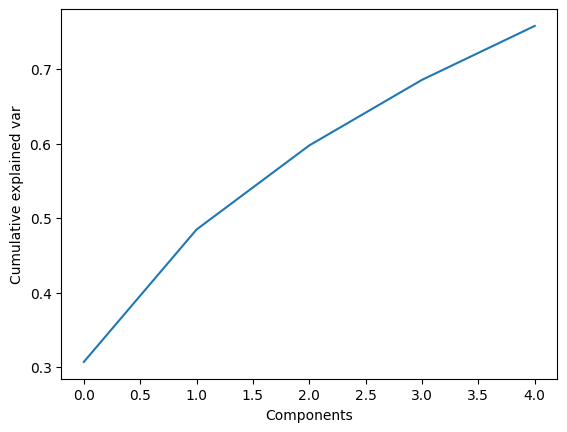

Training RandomForest & GradientBoosting on selected features...
Feature matrix shapes: (12857, 15) (2755, 15) (2756, 15)
Training RandomForest...
Training GradientBoosting...
Model comparison on TEST set:


,Model,RMSE,MAE,R2,MAPE(%),sMAPE(%)
0,GradientBoosting,0.037244,0.023474,0.999308,0.173470,0.173489
1,RandomForest,0.049364,0.028440,0.998785,0.209472,0.209430


Best model: GradientBoosting
Training complete. Models kept in memory (no dumps). You can now use the notebook's prediction cell.


In [9]:
# Cell 6: train pipeline (updated: show boxplots before/after, no file dumps)
# 0) Read raw for before-visualization
raw_df = pd.read_csv('dataset.csv')
raw_df.columns = [c.strip().replace(' ', '_') for c in raw_df.columns]
# identify numeric cols to visualize (a short list)
numeric_cols = raw_df.select_dtypes(include=[np.number]).columns.tolist()
viz_cols = [c for c in ['OccupancyRate','Occupancy','Capacity','QueueLength','TrafficLevel','VehicleWeight','Price'] if c in raw_df.columns]
if not viz_cols:
    viz_cols = numeric_cols[:6]

print("Boxplots BEFORE cleaning:")
visualize_boxplots(raw_df, cols=viz_cols, title="Before cleaning")

# 1) Load and preprocess (with outlier removal enabled)
df = load_and_preprocess_data('dataset.csv', verbose=True, remove_outliers=True)

# Optionally construct derived features (lags etc.)
df = construct_features(df)

# Recreate price via demand model if not present
if 'Price' not in df.columns:
    df = create_demand_pricing_model(df)

print("\nBoxplots AFTER cleaning & feature engineering:")
# some derived columns may not exist in raw; choose available ones
viz_cols_after = [c for c in ['OccupancyRate','QueueNorm','TrafficLevel','VehicleWeight','Price'] if c in df.columns]
visualize_boxplots(df, cols=viz_cols_after, title="After cleaning")

# 2) create lagged split
train_data, val_data, test_data = create_lagged_features_and_split(df)
print(f"Train/Val/Test sizes: {len(train_data)}/{len(val_data)}/{len(test_data)}")

# 3) quick EDA (optional; can be commented if slow)
understand_relationships_and_test(train_data)

# 4) feature candidate selection
candidate_features = [
    'Capacity','Latitude','Longitude','OccupancyRate_lag1','OccupancyRate_lag2','OccupancyRate_lag3',
    'OccupancyRate_rm3','QueueNorm','TrafficLevel','IsSpecialDay','VehicleWeight',
    'Hour','DayOfWeek','IsWeekend','Month',
    'Occupancy_x_Queue','VehicleWeight_x_Traffic','IsPeakHour'
]
candidate_features = [f for f in candidate_features if f in train_data.columns]

# 5) feature selection
final_features, scaler_for_pca, pca = select_features_and_reduce(train_data, val_data, candidate_features, k=12)

# 6) train & evaluate
models, results, importances = train_and_evaluate_models(train_data, val_data, test_data, final_features)

# 7) choose best & proximity
best_model_name = min(results.items(), key=lambda x: x[1]['test_metrics']['RMSE'])[0]
print("Best model:", best_model_name)
proximity_info = compute_proximity_measures(train_data, final_features)

# 8) retrain final_model on train+val for inference
full_train = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
final_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
final_model.fit(full_train[final_features].fillna(0), full_train['Price'])




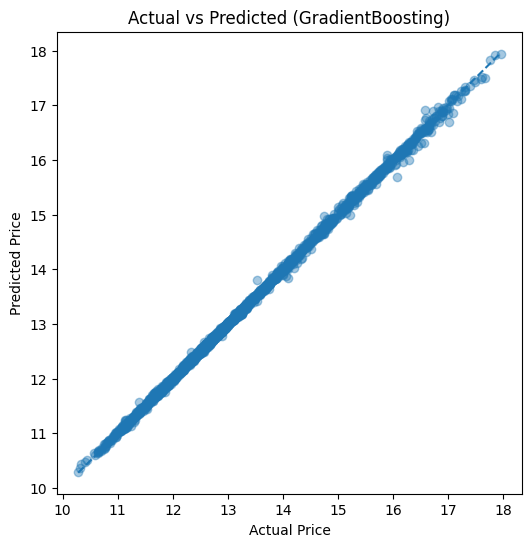

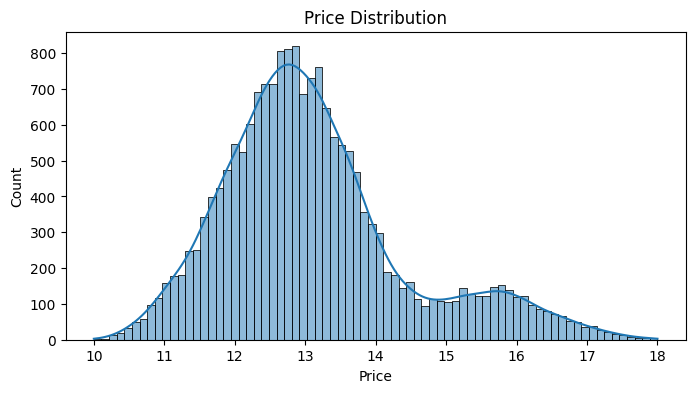

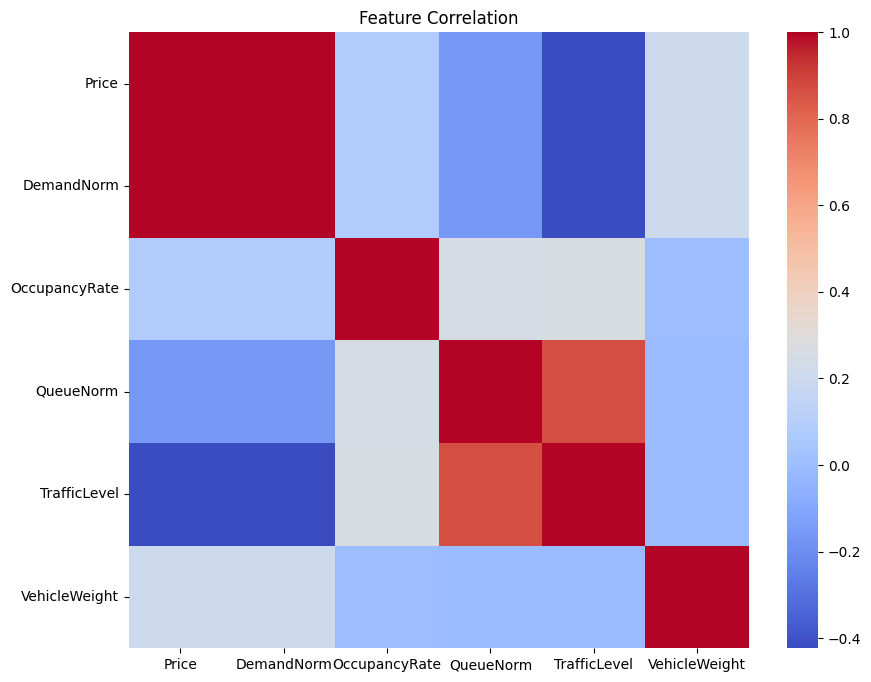

In [10]:
# Cell 7: plots for test diagnostics
# requires results variable from Cell 6
try:
    # pick the best model's test predictions if present
    test_pred = results[best_model_name]['test_pred']
    plot_actual_vs_pred(test_data['Price'], test_pred, title=f'Actual vs Predicted ({best_model_name})')
    plot_price_distribution(df)
    sample_cols = [c for c in ['Price','DemandNorm','OccupancyRate','QueueNorm','TrafficLevel','VehicleWeight'] if c in df.columns]
    plot_feature_correlation(df, feature_cols=sample_cols)
except Exception as e:
    print("Plotting error (maybe results not present):", e)


In [11]:
# Cell 8: Manual test (in-notebook). Assumes final_model & final_features are in memory.


if 'final_model' not in globals() or 'final_features' not in globals():
    raise RuntimeError("final_model/final_features not found in memory. Run the training cell (Cell 6) first.")

model = final_model
features = final_features
prox = proximity_info
train_df = full_train

# Example test values (edit as you like)
sample_dict = {
    "OccupancyRate_lag1": 0.82,
    "OccupancyRate_lag2": 0.70,
    "QueueNorm": 0.15,
    "TrafficLevel": 1,
    "VehicleWeight": 1,
    "Hour": 9,
    "DayOfWeek": 5,
    "IsWeekend": 1,
    "IsSpecialDay": 0,
    "Occupancy_x_Queue": 0.82 * 0.15,
    "VehicleWeight_x_Traffic": 1 * 1,
    "IsPeakHour": 1
}

row = {f: float(sample_dict.get(f, train_df[f].median() if f in train_df.columns else 0.0)) for f in features}
sample_df = pd.DataFrame([row])[features].fillna(0)

pred = model.predict(sample_df)[0]
print("Predicted Parking Price:", round(pred,2))

# show nearby historical records



Predicted Parking Price: 12.96

Nearest historical records:
 idx=2864, dist=1.929, Price=12.75, Time=2016-10-15 11:01:00
 idx=5805, dist=1.941, Price=12.18, Time=2016-10-29 07:59:00
 idx=1113, dist=1.969, Price=12.57, Time=2016-10-08 11:30:00
 idx=4124, dist=2.060, Price=12.48, Time=2016-10-22 10:59:00
 idx=5806, dist=2.101, Price=12.63, Time=2016-10-29 07:59:00


In [22]:
def predict_from_dict(sample_dict, model=final_model, features=final_features, train_df=full_train, prox=proximity_info):
    """Predict parking price and display a clear, readable explanation."""
    # Prepare input row
    row = {f: float(sample_dict.get(f, train_df[f].median() if f in train_df.columns else 0.0)) for f in features}
    sample_df = pd.DataFrame([row])[features].fillna(0)

    # Predict price
    pred = model.predict(sample_df)[0]
    price = float(round(pred, 2))

    # Basic interpretation of demand level
    if price <= 8:
        level = "🟢 Low demand"
    elif 8 < price <= 12:
        level = "🟡 Moderate demand"
    elif 12 < price <= 16:
        level = "🟠 High demand"
    else:
        level = "🔴 Peak demand"

    # Output explanation
    print("🚗 Parking Price Prediction")
    print("----------------------------")
    print(f"Predicted Parking Price: ₹{price:.2f} per hour")
    print(f"Demand Level: {level}")
    print(f"Conditions: Occupancy={sample_dict.get('OccupancyRate_lag1', 'N/A')}, "
          f"Traffic={sample_dict.get('TrafficLevel', 'N/A')}, "
          f"Queue={sample_dict.get('QueueNorm', 'N/A')}, "
          f"SpecialDay={sample_dict.get('IsSpecialDay', 'N/A')}")
    print("----------------------------")

    return price




predict_from_dict({
    "OccupancyRate_lag1": 0.82,
    "OccupancyRate_lag2": 0.70,
    "QueueNorm": 0.15,
    "TrafficLevel": 1,
    "VehicleWeight": 1,
    "Hour": 9,
    "DayOfWeek": 5,
    "IsWeekend": 1,
    "IsSpecialDay": 0,
    "Occupancy_x_Queue": 0.82 * 0.15,
    "VehicleWeight_x_Traffic": 1 * 1,
    "IsPeakHour": 1
})

try:
    scaler = prox['scaler']; nbrs = prox['nbrs']; Xs_train = prox['Xs']
    xs = scaler.transform(sample_df.values)
    dists, idxs = nbrs.kneighbors(xs, n_neighbors=min(5, Xs_train.shape[0]))
    pooled = train_df.reset_index(drop=True)
    print("\nNearest historical records:")
    for dist, idx in zip(dists[0], idxs[0]):
        r = pooled.iloc[idx]
        print(f" idx={idx}, dist={dist:.3f}, Price={r.get('Price',np.nan):.2f}, Time={r.get('LastUpdatedTimestamp')}")
except Exception as e:
    print("Nearest neighbors unavailable:", e)


🚗 Parking Price Prediction
----------------------------
Predicted Parking Price: ₹12.96 per hour
Demand Level: 🟠 High demand
Conditions: Occupancy=0.82, Traffic=1, Queue=0.15, SpecialDay=0
----------------------------

Nearest historical records:
 idx=2864, dist=1.929, Price=12.75, Time=2016-10-15 11:01:00
 idx=5805, dist=1.941, Price=12.18, Time=2016-10-29 07:59:00
 idx=1113, dist=1.969, Price=12.57, Time=2016-10-08 11:30:00
 idx=4124, dist=2.060, Price=12.48, Time=2016-10-22 10:59:00
 idx=5806, dist=2.101, Price=12.63, Time=2016-10-29 07:59:00
